In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import os

import time
import copy
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn.functional as F

from sklearn import decomposition


In [3]:
import torch_4DVarNN_dinAE as NN_4DVar

In [4]:
flagRandomSeed = 0
if flagRandomSeed == 0:
  print('........ Random seed set to 100')
  np.random.seed(100)
  torch.manual_seed(100)


........ Random seed set to 100


In [5]:
#Data simulation and preparation (patch extraction, missing data + noise)

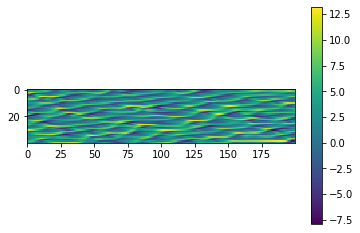

In [6]:
from scipy.integrate import solve_ivp
def AnDA_Lorenz_96(S,t,F,J):
    """ Lorenz-96 dynamical model. """
    x = np.zeros(J);
    x[0] = (S[1]-S[J-2])*S[J-1]-S[0];
    x[1] = (S[2]-S[J-1])*S[0]-S[1];
    x[J-1] = (S[0]-S[J-3])*S[J-2]-S[J-1];
    for j in range(2,J-1):
        x[j] = (S[j+1]-S[j-2])*S[j-1]-S[j];
    dS = x.T + F;
    return dS


class GD:
    model = 'Lorenz_96'
    class parameters:
        F = 8
        J = 40
    dt_integration = 0.05 # integration time
    dt_states = 1 # number of integration times between consecutive states (for xt and catalog)
    dt_obs = 4 # number of integration times between consecutive observations (for yo)
    var_obs = np.random.permutation(parameters.J)[0:20] # indices of the observed variables
    nb_loop_train = 10**4 # size of the catalog
    nb_loop_test = 10 # size of the true state and noisy observations
    sigma2_catalog = 0   # variance of the model error to generate the catalog   
    sigma2_obs = 2 # variance of the observation error to generate observations

class time_series:
  values = 0.
  time   = 0.

# 5 time steps (to be in the attractor space)
GD = GD()    
x0 = GD.parameters.F*np.ones(GD.parameters.J);
x0[np.int(np.around(GD.parameters.J/2))] = x0[np.int(np.around(GD.parameters.J/2))] + 0.01
#S = odeint(AnDA_Lorenz_96,x0,np.arange(0,5+0.000001,GD.dt_integration),args=(GD.parameters.F,GD.parameters.J));
S = solve_ivp(fun=lambda t,y: AnDA_Lorenz_96(y,t,GD.parameters.F,GD.parameters.J),t_span=[0.,5+0.000001],y0=x0,first_step=GD.dt_integration,t_eval=np.arange(0,5+0.000001,GD.dt_integration),method='RK45')
x0 = S.y[:,-1]

# generate true state (xt)
#S = odeint(AnDA_Lorenz_96,x0,np.arange(0.01,GD.nb_loop_test+0.000001,GD.dt_integration),args=(GD.parameters.F,GD.parameters.J));       
tt = np.arange(GD.dt_integration,GD.nb_loop_train*GD.dt_integration+0.000001,GD.dt_integration)
S = solve_ivp(fun=lambda t,y: AnDA_Lorenz_96(y,t,GD.parameters.F,GD.parameters.J),t_span=[GD.dt_integration,GD.nb_loop_train*GD.dt_integration+0.000001],y0=x0,first_step=GD.dt_integration,t_eval=tt,method='RK45')
S = S.y.transpose()

plt.figure(1)
plt.imshow(S[0:200,:].transpose())
plt.colorbar()  
  
xt = time_series()
xt.values = S
xt.time   = tt

In [7]:
from sklearn.feature_extraction import image
            
NbTraining = 2000#2000
NbTest     = 256#256#500
time_step  = 1
dT         = 201
sigNoise   = np.sqrt(2)
rateMissingData = 0.75#0.95
  
xt = time_series()
xt.values = S
xt.time   = tt
# extract subsequences
dataTrainingNoNaN = image.extract_patches_2d(xt.values[0:7000:time_step,:],(dT,GD.parameters.J),NbTraining)
dataTestNoNaN     = image.extract_patches_2d(xt.values[7500::time_step,:],(dT,GD.parameters.J),NbTest)

# create missing data
flagTypeMissData = 1
if flagTypeMissData == 0:
    indRand         = np.random.permutation(dataTrainingNoNaN.shape[0]*dataTrainingNoNaN.shape[1]*dataTrainingNoNaN.shape[2])
    indRand         = indRand[0:int(rateMissingData*len(indRand))]
    dataTraining    = np.copy(dataTrainingNoNaN).reshape((dataTrainingNoNaN.shape[0]*dataTrainingNoNaN.shape[1]*dataTrainingNoNaN.shape[2],1))
    dataTraining[indRand] = float('nan')
    dataTraining    = np.reshape(dataTraining,(dataTrainingNoNaN.shape[0],dataTrainingNoNaN.shape[1],dataTrainingNoNaN.shape[2]))
    
    indRand         = np.random.permutation(dataTestNoNaN.shape[0]*dataTestNoNaN.shape[1]*dataTestNoNaN.shape[2])
    indRand         = indRand[0:int(rateMissingData*len(indRand))]
    dataTest        = np.copy(dataTestNoNaN).reshape((dataTestNoNaN.shape[0]*dataTestNoNaN.shape[1]*dataTestNoNaN.shape[2],1))
    dataTest[indRand] = float('nan')
    dataTest          = np.reshape(dataTest,(dataTestNoNaN.shape[0],dataTestNoNaN.shape[1],dataTestNoNaN.shape[2]))

    genSuffixObs    = '_ObsRnd_%02d_%02d'%(100*rateMissingData,10*sigNoise**2)
else:
    time_step_obs   = int(1./(1.-rateMissingData))
    dataTraining    = np.zeros((dataTrainingNoNaN.shape))
    dataTraining[:] = float('nan')
    dataTest        = np.zeros((dataTestNoNaN.shape))
    dataTest[:]     = float('nan')
    
    if 1*0:
        dataTraining[:,::time_step_obs,:] = dataTrainingNoNaN[:,::time_step_obs,:]
        dataTest[:,::time_step_obs,:]     = dataTestNoNaN[:,::time_step_obs,:]
        
        genSuffixObs    = '_ObsSub_%02d_%02d'%(100*rateMissingData,10*sigNoise**2)
    else:
        for nn in range(0,dataTraining.shape[1],time_step_obs):
            indrand = np.random.permutation(dataTraining.shape[2])[0:int(0.5*dataTraining.shape[2])]
            dataTraining[:,nn,indrand] = dataTrainingNoNaN[:,nn,indrand]

        for nn in range(0,dataTraining.shape[1],time_step_obs):
            indrand = np.random.permutation(dataTraining.shape[2])[0:int(0.5*dataTraining.shape[2])]
            dataTest[:,nn,indrand] = dataTestNoNaN[:,nn,indrand]

        genSuffixObs    = '_ObsSubRnd_%02d_%02d'%(100*rateMissingData,10*sigNoise**2)
    print('... Data type: '+genSuffixObs)
    #for nn in range(0,dataTraining.shape[1],time_step_obs):
    #    dataTraining[:,::time_step_obs,:] = dataTrainingNoNaN[:,::time_step_obs,:]
    
    #dataTest    = np.zeros((dataTestNoNaN.shape))
    #dataTest[:] = float('nan')
    #dataTest[:,::time_step_obs,:] = dataTestNoNaN[:,::time_step_obs,:]

    
# set to NaN patch boundaries
if 1*0:
    dataTraining[:,0:10,:] =  float('nan')
    dataTest[:,0:10,:]     =  float('nan')
    dataTraining[:,dT-10:dT,:] =  float('nan')
    dataTest[:,dT-10:dT,:]     =  float('nan')

# mask for NaN
maskTraining = (dataTraining == dataTraining).astype('float')
maskTest     = ( dataTest    ==  dataTest   ).astype('float')

dataTraining = np.nan_to_num(dataTraining)
dataTest     = np.nan_to_num(dataTest)

# Permutation to have channel as #1 component
dataTraining      = np.moveaxis(dataTraining,-1,1)
maskTraining      = np.moveaxis(maskTraining,-1,1)
dataTrainingNoNaN = np.moveaxis(dataTrainingNoNaN,-1,1)

dataTest      = np.moveaxis(dataTest,-1,1)
maskTest      = np.moveaxis(maskTest,-1,1)
dataTestNoNaN = np.moveaxis(dataTestNoNaN,-1,1)

# set to NaN patch boundaries
#dataTraining[:,0:5,:] =  dataTrainingNoNaN[:,0:5,:]
#dataTest[:,0:5,:]     =  dataTestNoNaN[:,0:5,:]

############################################
## raw data
X_train         = dataTrainingNoNaN
X_train_missing = dataTraining
mask_train      = maskTraining

X_test         = dataTestNoNaN
X_test_missing = dataTest
mask_test      = maskTest

############################################
## normalized data
meanTr          = np.mean(X_train_missing[:]) / np.mean(mask_train) 

x_train_missing = X_train_missing - meanTr
x_test_missing  = X_test_missing - meanTr

# scale wrt std
stdTr           = np.sqrt( np.mean( X_train_missing**2 ) / np.mean(mask_train) )
x_train_missing = x_train_missing / stdTr
x_test_missing  = x_test_missing / stdTr

x_train = (X_train - meanTr) / stdTr
x_test  = (X_test - meanTr) / stdTr


# Generate noisy observsation
X_train_obs = X_train_missing + sigNoise * maskTraining * np.random.randn(X_train_missing.shape[0],X_train_missing.shape[1],X_train_missing.shape[2])
X_test_obs  = X_test_missing  + sigNoise * maskTest * np.random.randn(X_test_missing.shape[0],X_test_missing.shape[1],X_test_missing.shape[2])

x_train_obs = (X_train_obs - meanTr) / stdTr
x_test_obs  = (X_test_obs - meanTr) / stdTr

print('..... Training dataset: %dx%dx%d'%(x_train.shape[0],x_train.shape[1],x_train.shape[2]))
print('..... Test dataset    : %dx%dx%d'%(x_test.shape[0],x_test.shape[1],x_test.shape[2]))


... Data type: _ObsSubRnd_75_20
..... Training dataset: 2000x40x201
..... Test dataset    : 256x40x201


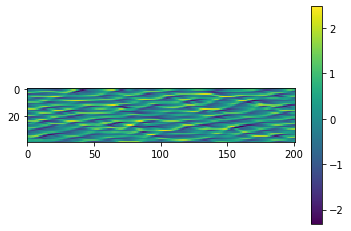

In [8]:
idx = 180

# Visualisation
plt.figure(1)
plt.imshow(x_train[idx,:,:].squeeze())
plt.colorbar()  

In [9]:
# Initial interpolation

In [10]:
print('........ Initialize interpolated states')
import scipy

# Initialization for interpolation
flagInit = 1

if flagInit == 0: 
  X_train_Init = mask_train * X_train_obs + (1. - mask_train) * (np.zeros(X_train_missing.shape) + meanTr)
  X_test_Init  = mask_test * X_test_obs + (1. - mask_test) * (np.zeros(X_test_missing.shape) + meanTr)
else:
  X_train_Init = np.zeros(X_train.shape)
  for ii in range(0,X_train.shape[0]):
    # Initial linear interpolation for each component
    XInit = np.zeros((X_train.shape[1],X_train.shape[2]))

    for kk in range(0,mask_train.shape[1]):
      indt  = np.where( mask_train[ii,kk,:] == 1.0 )[0]
      indt_ = np.where( mask_train[ii,kk,:] == 0.0 )[0]

      if len(indt) > 1:
        indt_[ np.where( indt_ < np.min(indt)) ] = np.min(indt)
        indt_[ np.where( indt_ > np.max(indt)) ] = np.max(indt)
        fkk = scipy.interpolate.interp1d(indt, X_train_obs[ii,kk,indt])
        XInit[kk,indt]  = X_train_obs[ii,kk,indt]
        XInit[kk,indt_] = fkk(indt_)
      else:
        XInit = XInit + meanTr

    X_train_Init[ii,:,:] = XInit

  X_test_Init = np.zeros(X_test.shape)
  for ii in range(0,X_test.shape[0]):
    # Initial linear interpolation for each component
    XInit = np.zeros((X_test.shape[1],X_test.shape[2]))

    for kk in range(0,X_test.shape[1]):
      indt  = np.where( mask_test[ii,kk,:] == 1.0 )[0]
      indt_ = np.where( mask_test[ii,kk,:] == 0.0 )[0]

      if len(indt) > 1:
        indt_[ np.where( indt_ < np.min(indt)) ] = np.min(indt)
        indt_[ np.where( indt_ > np.max(indt)) ] = np.max(indt)
        fkk = scipy.interpolate.interp1d(indt, X_test_obs[ii,kk,indt])
        XInit[kk,indt]  = X_test_obs[ii,kk,indt]
        XInit[kk,indt_] = fkk(indt_)
      else:
        XInit = XInit + meanTr

    X_test_Init[ii,:,:] = XInit
      #plt.figure()
      #plt.figure()
      #plt.plot(YObs[0:200,1],'r.')
      #plt.plot(XGT[0:200,1],'b-')
      #plt.plot(XInit[0:200,1],'k-')
            
x_train_Init = ( X_train_Init - meanTr ) / stdTr
x_test_Init = ( X_test_Init - meanTr ) / stdTr


# reshape to dT-1 for time dimension
dT = dT-1
X_train_obs        = X_train_obs[:,:,0:dT]
X_train            = X_train[:,:,0:dT]
X_train_missing    = X_train_missing[:,:,0:dT]
mask_train         = mask_train[:,:,0:dT]

x_train_obs        = x_train_obs[:,:,0:dT]
x_train            = x_train[:,:,0:dT]
x_train_Init       = x_train_Init[:,:,0:dT]
X_train_Init       = X_train_Init[:,:,0:dT]

X_test_obs        = X_test_obs[:,:,0:dT]
X_test            = X_test[:,:,0:dT]
X_test_missing    = X_test_missing[:,:,0:dT]
mask_test         = mask_test[:,:,0:dT]

x_test_obs        = x_test_obs[:,:,0:dT]
x_test            = x_test[:,:,0:dT]
x_test_Init       = x_test_Init[:,:,0:dT]
X_test_Init       = X_test_Init[:,:,0:dT]

print('..... Training dataset: %dx%dx%d'%(x_train.shape[0],x_train.shape[1],x_train.shape[2]))
print('..... Test dataset    : %dx%dx%d'%(x_test.shape[0],x_test.shape[1],x_test.shape[2]))

........ Initialize interpolated states
..... Training dataset: 2000x40x200
..... Test dataset    : 256x40x200


# Create AE architecture

In [23]:
shapeData = np.ones(3).astype(int)
shapeData[1:] =  x_train.shape[1:]
# freeze all ode parameters

flagAEType = 0
DimAE      = 50
if flagAEType == 0: ## AE using ode_L96 (conv2d implementation)

    class Encoder(torch.nn.Module):
        def __init__(self):
              super(Encoder, self).__init__()
              self.F         = torch.nn.Parameter(torch.Tensor([8.]))
              self.dt        = 0.05
              self.IntScheme = 1
              self.stdTr     = stdTr
              self.meanTr    = meanTr
              #self.conv1     = torch.nn.Conv2d(1,shapeData[0],1,padding=0,bias=False)
            
              self.conv1     = torch.nn.Conv2d(1,1,(5,1),padding=0,bias=False)
              self.conv2     = torch.nn.Conv2d(1,1,(3,1),padding=0,bias=False)

              # predefined parameters
              K = torch.Tensor([-1.,0.,0.,1.,0.]).view(1,1,5,1)
              self.conv1.weight = torch.nn.Parameter(K)
              K = torch.Tensor([1.,0.,0.]).view(1,1,3,1)
              self.conv2.weight = torch.nn.Parameter(K)

        def _odeL96(self, xin):
            x_1 = torch.cat((xin[:,:,xin.size(2)-2:,:],xin,xin[:,:,0:2,:]),dim=2)
            #x_1 = x_1.view(-1,1,xin.size(1)+4,xin.size(2))
            x_1 = self.conv1( x_1 )                
            #x_1 = x_1.view(-1,xin.size(1),xin.size(2))

            x_2 = torch.cat((xin[:,:,xin.size(2)-1:,:],xin,xin[:,:,0:1,:]),dim=2)
            #x_2 = x_2.view(-1,1,xin.size(1)+2,xin.size(2))
            x_2 = self.conv2( x_2 )
            #x_2 = x_2.view(-1,xin.size(1),xin.size(2))
                    
            dpred = x_1 * x_2 - xin + self.F
    
            return dpred.view(-1,xin.size(1),xin.size(2),xin.size(3))

        def _EulerSolver(self, x):
            return x + self.dt * self._odeL96(x)

        def _RK4Solver(self, x):
            k1 = self._odeL96(x)
            x2 = x + 0.5 * self.dt * k1
            k2 = self._odeL96(x2)
          
            x3 = x + 0.5 * self.dt * k2
            k3 = self._odeL96(x3)
              
            x4 = x + self.dt * k3
            k4 = self._odeL96(x4)

            return x + self.dt * (k1+2.*k2+2.*k3+k4)/6.
      
        def forward(self, x):
            X = self.stdTr * x 
            X = X + self.meanTr
            
            if self.IntScheme == 0:
                xpred = self._EulerSolver( X[:,:,:,0:x.size(3)-1] )
            else:
                xpred = self._RK4Solver( X[:,:,:,0:x.size(3)-1] )

            xpred = xpred - self.meanTr
            xpred = xpred / self.stdTr

            xnew  = torch.cat((x[:,:,:,0].view(-1,1,x.size(2),1),xpred),dim=3)
            return xnew

    class Decoder(torch.nn.Module):
      def __init__(self):
          super(Decoder, self).__init__()

      def forward(self, x):
          return torch.mul(1.,x)

    genSuffixModel = '_DinAE4DVarv1'  
    modelTemp      = Encoder()
    if modelTemp.IntScheme == 0 :
        genSuffixModel = genSuffixModel+'_L96EulerNN'
    elif modelTemp.IntScheme == 1 :
        genSuffixModel = genSuffixModel+'_L96RK4NN'
        
elif flagAEType == 1: ## Same as flagAEType == 3 with no constraint on central point
  dW = 5
  genSuffixModel = '2SCNN'
  class Encoder(torch.nn.Module):
      def __init__(self):
          super(Encoder, self).__init__()
          self.pool1  = torch.nn.AvgPool2d((1,4))
          self.conv11 = torch.nn.Conv2d(1,DimAE,(2*dW+1,2*dW+1),padding=dW,bias=False)                      
          self.conv12 = torch.nn.Conv2d(DimAE,DimAE,(1,1),padding=0,bias=False)
          self.conv21 = torch.nn.Conv2d(DimAE,DimAE,(1,1),padding=0,bias=False)
          self.conv22 = torch.nn.Conv2d(DimAE,DimAE,(1,1),padding=0,bias=False)
          self.conv23 = torch.nn.Conv2d(DimAE,DimAE,(1,1),padding=0,bias=False)
          self.conv3  = torch.nn.Conv2d(2*DimAE,DimAE,(1,1),padding=0,bias=False)

          self.convTr = torch.nn.ConvTranspose2d(DimAE,DimAE,(1,4),stride=(1,4),bias=False)          
          #self.conv5 = torch.nn.Conv1d(8*shapeData[0]*DimAE,16*shapeData[0]*DimAE,3,padding=1,bias=False)
          #self.conv6 = torch.nn.Conv1d(16*shapeData[0]*DimAE,shapeData[0],3,padding=1,bias=False)
          self.conv11_1 = torch.nn.Conv2d(1,DimAE,(2*dW+1,2*dW+1),padding=dW,bias=False)                      
          self.conv12_1 = torch.nn.Conv2d(DimAE,DimAE,(1,1),padding=0,bias=False)
          self.conv21_1 = torch.nn.Conv2d(DimAE,DimAE,(1,1),padding=0,bias=False)
          self.conv22_1 = torch.nn.Conv2d(DimAE,DimAE,(1,1),padding=0,bias=False)
          self.conv23_1 = torch.nn.Conv2d(DimAE,DimAE,(1,1),padding=0,bias=False)
          self.conv3_1  = torch.nn.Conv2d(2*DimAE,DimAE,(1,1),padding=0,bias=False)

          self.convF    = torch.nn.Conv2d(DimAE,1,1,padding=0,bias=False)
      def forward(self, xin):
          x_1 = self.pool1(xin)
          x_1 = torch.cat((x_1[:,:,x_1.size(2)-dW:,:],x_1,x_1[:,:,0:dW,:]),dim=2)
          #x_1 = x_1.view(-1,1,xin.size(1)+2*dW,xin.size(2))
          x   = self.conv11( x_1 )
          x   = self.conv12( F.relu(x) )
          x   = x[:,:,dW:xin.size(2)+dW,:]
          x   = torch.cat((self.conv21(x), self.conv22(x) * self.conv23(x)),dim=1)
          x   = self.conv3( x )
          x   = self.convTr( x )

          x_2 = torch.cat((xin[:,:,xin.size(2)-dW:,:],xin,xin[:,:,0:dW,:]),dim=2)
          dx  = self.conv11_1( x_2 )
          dx  = self.conv12_1( F.relu(dx) )
          dx   = dx[:,:,dW:xin.size(2)+dW,:]
          dx   = torch.cat((self.conv21_1(dx), self.conv22_1(dx) * self.conv23_1(dx)),dim=1)
          dx   = self.conv3_1( dx )

          x    = self.convF( x + dx )
          #x = self.conv4( F.relu(x) )
          x = x.view(-1,shapeData[0],shapeData[1],shapeData[2])
          return x
  class Decoder(torch.nn.Module):
      def __init__(self):
          super(Decoder, self).__init__()

      def forward(self, x):
          return torch.mul(1.,x)


class Model_AE(torch.nn.Module):
    def __init__(self):
        super(Model_AE, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        x = self.encoder( x )
        x = self.decoder( x )
        return x

model_AE           = Model_AE()
print('AE Model type: '+genSuffixModel)
print(model_AE)
print('Number of trainable parameters = %d'%(sum(p.numel() for p in model_AE.parameters() if p.requires_grad)))


AE Model type: _DinAE4DVarv1_L96RK4NN
Model_AE(
  (encoder): Encoder(
    (conv1): Conv2d(1, 1, kernel_size=(5, 1), stride=(1, 1), bias=False)
    (conv2): Conv2d(1, 1, kernel_size=(3, 1), stride=(1, 1), bias=False)
  )
  (decoder): Decoder()
)
Number of trainable parameters = 9


# Evaluation of pre-trained models

In [24]:
UsePriodicBoundary = True # use a periodic boundary for all conv operators in the gradient model (see torch_4DVarNN_dinAE)
InterpFlag         = False

#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(".... Device GPU: "+str(torch.cuda.is_available()))

# mean-squared error loss
#criterion = torch.nn.MSELoss()
var_Tr    = np.var( x_train )
var_Tt    = np.var( x_test )
              
alpha4DVar      = np.array([0.1,1.])
GradType        = 1 # Gradient computation (0: subgradient, 1: true gradient/autograd)
OptimType       = 2 # 0: fixed-step gradient descent, 1: ConvNet_step gradient descent, 2: LSTM-based descent

NBGradCurrent   = 20
NBProjCurrent   = 0
batch_size      = 128

model           = NN_4DVar.Model_4DVarNN_GradFP(model_AE,shapeData,NBProjCurrent,NBGradCurrent,GradType,OptimType,InterpFlag,UsePriodicBoundary)        
#model           = NN_4DVar.Model_4DVarNN_Grad(model_AE,shapeData,NBGradCurrent,GradType,OptimType,InterpFlag,UsePriodicBoundary)        
        
model           = model.to(device)
print('4DVar model: Number of trainable parameters = %d'%(sum(p.numel() for p in model.parameters() if p.requires_grad)))
              
flagLoadModel   = 1

# Classic Supervised Learning model using GENN models
if( flagAEType == 1 ) :
    fileAEModelInit = 'l96_v3_2SCNN_Grad_01_02_20_modelAE.mod'
elif flagAEType == 0 :                
    fileAEModelInit = 'l96_v3_ODERK4_Grad_01_02_20_modelAE.mod'
print('.... load model: '+fileAEModelInit)

model.model_AE.load_state_dict(torch.load(fileAEModelInit))
model.model_Grad.load_state_dict(torch.load(fileAEModelInit.replace('_modelAE','_modelGrad')))

.... Device GPU: True
Opitm type 2
4DVar model: Number of trainable parameters = 1117
.... load model: l96_v3_ODERK4_Grad_01_02_20_modelAE.mod


<All keys matched successfully>

In [25]:
print('... Number of GPUs: %d'%torch.cuda.device_count())
if torch.cuda.device_count() > 1:
  print("Let's use", torch.cuda.device_count(), "GPUs!")
  # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
  modelMultiGPU = torch.nn.DataParallel(model)

  model_AEMultiGPU = torch.nn.DataParallel(model.model_AE)
  model_GradMultiGPU = torch.nn.DataParallel(model.model_Grad)
else:
  modelMultiGPU = model

modelMultiGPU.to(device)
model_AEMultiGPU.to(device)
model_GradMultiGPU.to(device)

... Number of GPUs: 4
Let's use 4 GPUs!


DataParallel(
  (module): model_GradUpdate2(
    (compute_Grad): Compute_Grad()
    (convLayer): Sequential(
      (0): Conv2d(5, 1, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
    (lstm): ConvLSTM2d(
      (Gates): Conv2d(6, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
  )
)

In [26]:
batch_size = 16

# Create training/test data pytorch tensors and associated  
# list of tensors (xx[n][x] to access the nth sample for the xth field)
training_dataset     = torch.utils.data.TensorDataset(torch.Tensor(x_train_Init),torch.Tensor(x_train_obs),torch.Tensor(mask_train),torch.Tensor(x_train)) # create your datset
test_dataset         = torch.utils.data.TensorDataset(torch.Tensor(x_test_Init),torch.Tensor(x_test_obs),torch.Tensor(mask_test),torch.Tensor(x_test)) # create your datset

dataloaders = {
    'train': torch.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True),
    'val': torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True),
}            
dataset_sizes = {'train': len(training_dataset), 'val': len(test_dataset)}

y_train = np.zeros(x_train.shape)
y_test  = np.zeros(x_test.shape)


# training function for dinAE
# Each epoch has a training and validation phase
for phase in ['val']:        
#for phase in ['train', 'val']:        

    since = time.time()

    model.eval()
    #if phase == 'train':
    #    #rint('Learning')
    #    model.train()  # Set model to training mode
    #else:
    #    #print('Evaluation')
    #    model.eval()   # Set model to evaluate mode

    running_loss_Obs     = 0.0
    running_loss_All     = 0.
    running_loss_R       = 0.
    running_loss_I       = 0.
    running_loss_AE      = 0.
    running_loss_AE_GT   = 0.
    running_loss_Obs_GT  = 0.
    num_loss             = 0
    idx = 0 # counter

    # Iterate over data.
    #for inputs_ in dataloaders[phase]:
    #    inputs = inputs_[0].to(device)
    for inputs_init,inputs_missing,masks,targets_GT in dataloaders[phase]:
        if( np.mod(idx,500) == 0) :
            print(".. "+phase+" data %d"%idx)
        inputs_init    = inputs_init.to(device)
        inputs_missing = inputs_missing.to(device)
        masks          = masks.to(device)
        targets_GT     = targets_GT.to(device)
        #print(inputs_init.size(0))


        # reshaping tensors
        inputs_init    = inputs_init.view(-1,1,inputs_init.size(1),inputs_init.size(2))
        inputs_missing = inputs_missing.view(-1,1,inputs_init.size(2),inputs_init.size(3))
        masks          = masks.view(-1,1,inputs_init.size(2),inputs_init.size(3))
        targets_GT     = targets_GT.view(-1,1,inputs_init.size(2),inputs_init.size(3))
                                
        # forward
        # need to evaluate grad/backward during the evaluation and training phase for model_AE
        with torch.set_grad_enabled(True): 
            #with torch.set_grad_enabled(phase == 'train'):
            inputs_init    = torch.autograd.Variable(inputs_init, requires_grad=True)
            if model.OptimType == 1:
                outputs,grad_new,normgrad = modelMultiGPU(inputs_init,inputs_missing,masks,None)
                
            elif model.OptimType == 2:
                outputs,hidden_new,cell_new,normgrad = modelMultiGPU(inputs_init,inputs_missing,masks,None,None)
                
            else:                               
                outputs,normgrad = modelMultiGPU(inputs_init,inputs_missing,masks)

            # store interpolation/reconstruction results
            if phase == 'train':
              y_train[idx:idx+inputs_missing.size(0),:,:] = outputs.cpu().detach().numpy().squeeze()
            else:
              y_test[idx:idx+inputs_missing.size(0),:,:]  = outputs.cpu().detach().numpy().squeeze()

            idx += inputs_missing.size(0)

            #outputs = model(inputs_init,inputs_missing,masks)
            
            loss_R      = torch.sum((outputs - targets_GT)**2 * masks ) / torch.sum(masks)
            loss_Obs    = torch.sum((outputs - inputs_missing)**2 * masks ) / torch.sum(masks)
            loss_I      = torch.sum((outputs - targets_GT)**2 * (1. - masks) ) / torch.sum(1.-masks)
            loss_All    = torch.mean((outputs - targets_GT)**2 )
            loss_AE     = torch.mean((model.model_AE(outputs) - outputs)**2 )

            loss_AE_GT  = torch.mean((model.model_AE(targets_GT) - targets_GT)**2 )
            loss_Obs_GT = torch.sum((targets_GT - inputs_missing)**2 * masks ) / torch.sum(masks)
            #loss_AE_GT  = torch.mean((mod.model_AE(targets_GT) - targets_GT)**2 )

            #loss  = alpha_Grad * loss_All + 0.5 * alpha_AE * ( loss_AE + loss_AE_GT )
            #if phase == 'train':                                 
            #    loss  = alpha_Grad * loss_All + 0.5 * alpha_AE * ( loss_AE + loss_AE_GT )
            #else:
            #    loss    = alpha_Grad * loss_R + alpha_AE * loss_AE

            # backward + optimize only if in training phase
                            
        # statistics
        running_loss_I           += loss_I.item() * inputs_missing.size(0)
        running_loss_R           += loss_R.item() * inputs_missing.size(0)
        running_loss_Obs         += loss_Obs.item() * inputs_missing.size(0)
        running_loss_Obs_GT      += loss_Obs_GT.item() * inputs_missing.size(0)
        running_loss_All         += loss_All.item() * inputs_missing.size(0)
        running_loss_AE_GT       += loss_AE_GT.item() * inputs_missing.size(0)
        running_loss_AE          += loss_AE.item() * inputs_missing.size(0)
        num_loss                 += inputs_missing.size(0)

    epoch_loss_All   = running_loss_All / num_loss
    epoch_loss_AE    = running_loss_AE / num_loss
    epoch_loss_AE_GT = running_loss_AE_GT / num_loss
    epoch_loss_I     = running_loss_I / num_loss
    epoch_loss_R     = running_loss_R / num_loss
    epoch_loss_Obs   = running_loss_Obs / num_loss
    epoch_loss_Obs_GT= running_loss_Obs_GT / num_loss
    #epoch_acc = running_corrects.double() / dataset_sizes[phase]

    epoch_loss_All   = epoch_loss_All * stdTr**2
    epoch_loss_I     = epoch_loss_I * stdTr**2
    epoch_loss_R     = epoch_loss_R * stdTr**2
    epoch_loss_Obs   = epoch_loss_Obs * stdTr**2
    epoch_loss_Obs_GT= epoch_loss_Obs_GT * stdTr**2
    epoch_loss_AE    = epoch_loss_AE * stdTr**2
    epoch_loss_AE_GT = epoch_loss_AE_GT * stdTr**2
    
    epoch_loss_4DVar = alpha4DVar[0] * epoch_loss_Obs + alpha4DVar[1] * epoch_loss_AE
    epoch_loss_4DVar_GT = alpha4DVar[0] * epoch_loss_Obs_GT + alpha4DVar[1] * epoch_loss_AE_GT

    print('{} Loss4DVar: {:.4e} Loss4DVarGT: {:.4e} NLossAll: {:.4e} NLossR: {:.4e} NLossI: {:.4e} NLossAE: {:.4e} NLossAEGT: {:.4e}'.format(
        phase, epoch_loss_4DVar,epoch_loss_4DVar_GT, epoch_loss_All,epoch_loss_R,epoch_loss_I,epoch_loss_AE,epoch_loss_AE_GT),flush=True)
        #print('... F %f'%model.model_AE.encoder.F)

    time_elapsed = time.time() - since
    print('Eval. time in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))

.. val data 0


/anaconda/envs/py37_pytorch/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


val Loss4DVar: 1.1353e-01 Loss4DVarGT: 1.9949e-01 NLossAll: 8.2697e-01 NLossR: 6.2112e-01 NLossI: 8.5638e-01 NLossAE: 2.5478e-02 NLossAEGT: 1.0696e-05
Eval. time in 0m 10s


In [27]:
if( flagAEType == 1 ) :
    y_test_2SCNN   = np.copy(y_test)
    err_test_2SNN =  stdTr**2 * np.sum(np.sum( (y_test_2SCNN[:,:,:]-x_test[:,:,:])**2,2),1) / (y_test_2SCNN.shape[1]*y_test_2SCNN.shape[2])  
elif flagAEType == 0 :                
    y_test_ODE   = np.copy(y_test)
    err_test_ODE = stdTr**2 * np.sum(np.sum( (y_test_ODE[:,:,:]-x_test[:,:,:])**2,2),1) / (y_test_ODE.shape[1]*y_test_ODE.shape[2])

In [16]:
# Evaluation for specific examples

In [16]:
np.random.seed(100)
idxTt    = np.random.permutation(x_test.shape[0])[0:4]

Text(0.5, 1.0, 'NN model 1.5513e-02')

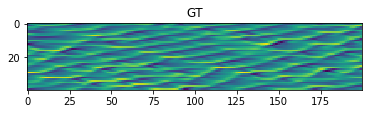

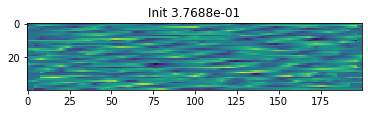

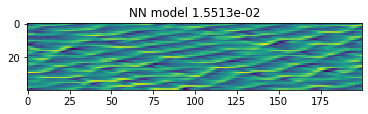

In [17]:
## Visualisation
#idxTr = np.random.permutation(y_train.shape[0])[0:2]
#idxTt = np.random.permutation(y_test.shape[0])[0:10]
ii = 0

plt.figure(1)
#plt.subplot(3,2,1)
plt.imshow(x_test[idxTt[ii],:,:].squeeze(),cmap='viridis')
plt.title('GT')

#plt.subplot(3,2,3)
plt.figure(2)
plt.imshow(x_test_Init[idxTt[ii],:,:].squeeze(),cmap='viridis')
plt.title('Init %.4e'%np.mean( (x_test_Init[idxTt[ii],:,:]-x_test[idxTt[ii],:,:])**2 ))

#plt.subplot(3,2,5)
plt.figure(4)
plt.imshow(y_test[idxTt[ii],:,:].squeeze(),cmap='viridis')
plt.title('NN model %.4e'%np.mean( (y_test[idxTt[ii],:,:]-x_test[idxTt[ii],:,:])**2 ))

In [ ]:
#Variational reconstruction using pre-trained prior and fixed-step gradient descent

In [28]:
# Variational assimilation reconstruction
# for test data indices idxTt
device  = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print('... alphaObs %.3f'%model.model_Grad.compute_Grad.alphaObs.item())    
print('... alphaPrior %.3f'%model.model_Grad.compute_Grad.alphaAE.item())    
print('... AEType %d'%flagAEType)

# model creation
batch_size      = len(idxTt)
alpha           = np.array([1.,0.1])
alpha4DVar      = np.array([0.1,1.])
alpha4DVar      = [model.model_Grad.compute_Grad.alphaObs.item(),model.model_Grad.compute_Grad.alphaAE.item()]
GradType        = 1 # Gradient computation (0: subgradient, 1: true gradient/autograd)
OptimType       = 2 # 0: fixed-step gradient descent, 1: ConvNet_step gradient descent, 2: LSTM-based descent
NiterProjection = 0 # Number of fixed-point iterations
NiterGrad       = 20 # Number of gradient descent step

print('.....')
print('..... alpha : obs %.3f --- dyn %.3f'%(alpha4DVar[0],alpha4DVar[1]))

#dt    = 0.01
StepLoss   = 50
NIter      = 1500#7500#650#1601#5000#
delta      = 1e2
ii = 0
idxTtOneBatch = idxTt#[ii:ii+1]

# Apply current model to data
test_dataset_OneBatch = torch.utils.data.TensorDataset(torch.Tensor(x_test_Init[idxTtOneBatch,:,:]),torch.Tensor(x_test_obs[idxTtOneBatch,:,:]),torch.Tensor(mask_test[idxTtOneBatch,:,:]),torch.Tensor(x_test[idxTtOneBatch,:,:])) # create your datset
dataloaders = {
    'val': torch.utils.data.DataLoader(test_dataset_OneBatch, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True),
}

x_test_pred  = []

compt   = 0
numData = 0

loss_dyn1 = torch.Tensor([0.0])
loss_obs1 = torch.Tensor([0.0])
loss_GT1  = torch.Tensor([0.0])            

phase   = 'val'
for x_init,x_obs,masks,x_GT in dataloaders[phase]:
    x_init    = x_init.to(device)
    x_obs     = x_obs.to(device)
    masks     = masks.to(device)
    x_GT      = x_GT.to(device)
    
    print(x_GT.size())
    # reshaping tensors
    x_init   = x_init.view(-1,1,x_init.size(1),x_init.size(2))
    x_obs    = x_obs.view(-1,1,x_obs.size(1),x_obs.size(2))
    masks    = masks.view(-1,1,masks.size(1),masks.size(2))
    x_GT     = x_GT.view(-1,1,x_GT.size(1),x_GT.size(2))

    #for phase in ['train', 'val']:    
    model.eval()
          
    compt    = compt + 1
    numData +=  x_GT.size(0)

    ## apply trained model AE + Grad for comparison
    with torch.set_grad_enabled(True): 
        #with torch.set_grad_enabled(phase == 'train'):
        x_init    = torch.autograd.Variable(x_init, requires_grad=True)
        if model.OptimType == 1:
            xhat1,grad_new,normgrad = modelMultiGPU(x_init,x_obs,masks,None)
            
        elif model.OptimType == 2:
            xhat1,hidden_new,cell_new,normgrad = modelMultiGPU(x_init,x_obs,masks,None,None)
            
        else:                               
            xhat1,normgrad = modelMultiGPU(x_init,x_obs,masks)
        
    loss_dyn1 = loss_dyn1 + x_GT.size(0) * torch.mean((xhat1 - model.model_AE( xhat1 ))**2 )
    loss_obs1 = loss_obs1 + x_GT.size(0) * torch.sum((xhat1 - x_obs)**2 * masks) / torch.sum( masks)
    loss_GT1  = loss_GT1 + x_GT.size(0) * torch.mean((xhat1 - x_GT)**2 )
    loss_dyn1 = loss_dyn1 / numData
    loss_obs1 = loss_obs1 / numData
    loss_GT1  = loss_GT1  / numData

    lossNN    = np.array([loss_GT1.cpu().detach().numpy(),loss_dyn1.cpu().detach().numpy(),loss_obs1.cpu().detach().numpy()])            
    
    print('..........................................')
    print('.....')
    print('..... Loss (trained Grad model) #d:  GT %.6e   ---  dyn %.6e   ---  obs %.6e'%(lossNN[0],lossNN[1],lossNN[2]))
    print('.....')
    print('.....')
    print('..... Fixed-step gradient-based descent of the variational cost')

    # AE projection
    xhat = x_init 
    #xhat = xhat1.detach()
    xhat = torch.autograd.Variable(xhat, requires_grad=True)

    # 4DVar assimilation using trained gradient descent
    losses_test = []
    compt_kk = 0
    for kk in range(0,NIter):
        # AE projection
        #x_pred = model.model_AE( xhat )
        x_pred = model_AEMultiGPU( xhat )
        
        # dynamical loss
        loss_dyn = torch.mean((xhat - x_pred)**2 )
    
        # observation loss
        loss_obs = torch.sum((xhat - x_obs)**2 * masks) / torch.sum( masks)
    
        ## loss wrt groudn-truth
        loss_GT  = torch.mean((xhat - x_GT)**2)
        loss_IGT = torch.sum((xhat - x_GT)**2 * (1.-masks)) / torch.sum( 1.-masks)

        # overall loss
        loss = alpha4DVar[0] * loss_obs + alpha4DVar[1] * loss_dyn 
    
        # compute gradient w.r.t. X and update X
        loss.backward()
        
        if( kk == 0 ):
            xhatBest = xhat.detach()
            lossBest = loss_GT.detach()
        else:
            if( loss_GT < lossBest ):
                xhatBest = xhat.detach()
                lossBest = loss_GT.detach()                                                          

        # evaluate and store losses
        if( np.mod(kk,StepLoss) == 0 ):  

            # store as np
            if( compt_kk == 0 ):
                losses_test  = torch.cat( (loss.view(1,1),loss_GT.view(1,1),loss_IGT.view(1,1),loss_dyn.view(1,1),loss_obs.view(1,1)), dim = 1 ).cpu().detach().numpy()                                
                losses_test *=  stdTr **2         
            else:
                losses = stdTr **2 * torch.cat( (loss.view(1,1),loss_GT.view(1,1),loss_IGT.view(1,1),loss_dyn.view(1,1),loss_obs.view(1,1)), dim = 1 )
                losses_test = np.concatenate( (losses_test,losses.cpu().detach().numpy()) , axis = 0)
            print('..... Loss Grad Descent %d:  4DVar %.6e   ---  GT %.6e   ---  Interp GT %.6e   ---  dyn %.6e   ---  obs %.6e'%(kk,losses_test[compt_kk,0],losses_test[compt_kk,1],losses_test[compt_kk,2],losses_test[compt_kk,3],losses_test[compt_kk,4]) )
            compt_kk = compt_kk + 1

        #grad_X  = torch.autograd.grad(loss,X_torch,create_graph=True)
        xhat = xhat - delta * xhat.grad.data
        xhat = torch.autograd.Variable(xhat, requires_grad=True)

loss4DVar     = losses_test
y_pred_VarMin = xhat.detach().cpu().numpy()
if( flagAEType == 1 ) :
  loss4DVar2SCNN = losses_test
  y_pred_VarMin2SCNN = xhatBest.detach().cpu().numpy()
elif flagAEType == 0 :                
  loss4DVarODE = losses_test
  y_pred_VarMinODE = xhatBest.detach().cpu().numpy()

... alphaObs 0.238
... alphaPrior 1.654
... AEType 0
.....
..... alpha : obs 0.238 --- dyn 1.654
torch.Size([4, 40, 200])
..........................................
.....
..... Loss (trained Grad model) #d:  GT 4.365938e-02   ---  dyn 1.344025e-03   ---  obs 4.772527e-02
.....
.....
..... Fixed-step gradient-based descent of the variational cost
..... Loss Grad Descent 0:  4DVar 1.385954e+00   ---  GT 7.142247e+00   ---  Interp GT 7.872776e+00   ---  dyn 8.381630e-01   ---  obs 0.000000e+00
..... Loss Grad Descent 50:  4DVar 8.552753e-01   ---  GT 6.561934e+00   ---  Interp GT 7.259772e+00   ---  dyn 4.908106e-01   ---  obs 1.835278e-01
..... Loss Grad Descent 100:  4DVar 6.834515e-01   ---  GT 6.194425e+00   ---  Interp GT 6.849888e+00   ---  dyn 3.715951e-01   ---  obs 2.898319e-01
..... Loss Grad Descent 150:  4DVar 5.895303e-01   ---  GT 5.915535e+00   ---  Interp GT 6.536699e+00   ---  dyn 3.076988e-01   ---  obs 3.391285e-01
..... Loss Grad Descent 200:  4DVar 5.290699e-01   --- 

In [29]:
# Sequential version of tre trained solver
# for idxTt samples
device  = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# model creation
batch_size      = len(idxTt)
alpha           = np.array([1.,0.1])
alpha4DVar      = np.array([0.1,1.])
alpha4DVar      = [model.model_Grad.compute_Grad.alphaObs.item(),model.model_Grad.compute_Grad.alphaAE.item()]
GradType        = 1 # Gradient computation (0: subgradient, 1: true gradient/autograd)
OptimType       = 2 # 0: fixed-step gradient descent, 1: ConvNet_step gradient descent, 2: LSTM-based descent
NiterProjection = 0 # Number of fixed-point iterations

print('.....')
print('..... alpha : obs %.3f --- dyn %.3f'%(alpha4DVar[0],alpha4DVar[1]))

#dt    = 0.01
NIter  = 20

# Apply current model to data
test_dataset_OneBatch = torch.utils.data.TensorDataset(torch.Tensor(x_test_Init[idxTtOneBatch,:,:]),torch.Tensor(x_test_obs[idxTtOneBatch,:,:]),torch.Tensor(mask_test[idxTtOneBatch,:,:]),torch.Tensor(x_test[idxTtOneBatch,:,:])) # create your datset
dataloaders = {
    'val': torch.utils.data.DataLoader(test_dataset_OneBatch, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True),
}

x_test_pred  = []

compt   = 0
numData = 0

loss_dyn1 = torch.Tensor([0.0])
loss_obs1 = torch.Tensor([0.0])
loss_GT1  = torch.Tensor([0.0])            

phase   = 'val'
for x_init,x_obs,masks,x_GT in dataloaders[phase]:
    x_init    = x_init.to(device)
    x_obs     = x_obs.to(device)
    masks     = masks.to(device)
    x_GT      = x_GT.to(device)
    
    print(x_GT.size())
    # reshaping tensors
    x_init   = x_init.view(-1,1,x_init.size(1),x_init.size(2))
    x_obs    = x_obs.view(-1,1,x_obs.size(1),x_obs.size(2))
    masks    = masks.view(-1,1,masks.size(1),masks.size(2))
    x_GT     = x_GT.view(-1,1,x_GT.size(1),x_GT.size(2))

    #for phase in ['train', 'val']:    
    model.eval()
          
    compt    = compt + 1
    numData +=  x_GT.size(0)

    ## apply trained model AE + Grad for comparison
    with torch.set_grad_enabled(True): 
        #with torch.set_grad_enabled(phase == 'train'):
        x_init    = torch.autograd.Variable(x_init, requires_grad=True)
        if model.OptimType == 1:
            xhat1,grad_new,normgrad = modelMultiGPU(x_init,x_obs,masks,None)
            
        elif model.OptimType == 2:
            xhat1,hidden_new,cell_new,normgrad = modelMultiGPU(x_init,x_obs,masks,None,None)
            
        else:                               
            xhat1,normgrad = modelMultiGPU(x_init,x_obs,masks)
        
    loss_dyn1 = loss_dyn1 + x_GT.size(0) * torch.mean((xhat1 - model.model_AE( xhat1 ))**2 )
    loss_obs1 = loss_obs1 + x_GT.size(0) * torch.sum((xhat1 - x_obs)**2 * masks) / torch.sum( masks)
    loss_GT1  = loss_GT1 + x_GT.size(0) * torch.mean((xhat1 - x_GT)**2 )
    loss_dyn1 = loss_dyn1 / numData
    loss_obs1 = loss_obs1 / numData
    loss_GT1  = loss_GT1  / numData

    lossNN    = np.array([loss_GT1.cpu().detach().numpy(),loss_dyn1.cpu().detach().numpy(),loss_obs1.cpu().detach().numpy()])            
    
    print('..........................................')
    print('.....')
    print('..... Loss (trained Grad model) #d:  GT %.6e   ---  dyn %.6e   ---  obs %.6e'%(lossNN[0],lossNN[1],lossNN[2]))
    print('.....')
    print('.....')
    print('..... Sequential applicaton of the trained model')
    # AE projection
    xhat = x_init 
    xhat = torch.autograd.Variable(xhat, requires_grad=True)

    grad     = model.model_Grad.compute_Grad(xhat, model.model_AE(xhat),x_obs,masks)
    normgrad = torch.sqrt( torch.mean( grad**2 ) )
                    
    losses_test = []
    compt_kk    = 0
    for kk in range(0,NIter+1):
        if kk > 0 :
          # AE projection
          x_pred = model.model_AE( xhat )
          
          # Compute Gradient-based update
          if model.OptimType == 0:
              grad  = model.model_Grad( xhat, x_pred, x_obs, masks, normgrad)
              #grad  = model_GradMultiGPU( xhat, x_pred, x_obs, masks, normgrad)
          elif model.OptimType == 1:
              if kk == 1:
                  #grad  = model_GradMultiGPU( xhat, x_pred, x_obs, masks, None, normgrad)

                  grad  = model.model_Grad( xhat, x_pred, x_obs, masks, None, normgrad)
              else:
                  #grad  = model_GradMultiGPU( xhat, x_pred, x_obs, masks, grad_old, normgrad)
                  grad  = model.model_Grad( xhat, x_pred, x_obs, masks, grad_old, normgrad)

              grad_old = 1. * grad
          elif model.OptimType == 2:
              if kk == 1:
                  #grad,hidden,cell  = model_GradMultiGPU( xhat, x_pred, x_obs, masks, None,None, normgrad)
                  grad,hidden,cell  = model.model_Grad( xhat, x_pred, x_obs, masks, None,None, normgrad)

              else:
                  #grad,hidden,cell  = model_GradMultiGPU( xhat, x_pred, x_obs, masks, hidden, cell, normgrad)            
                  grad,hidden,cell  = model.model_Grad( xhat, x_pred, x_obs, masks, hidden, cell, normgrad)            

          xhat = xhat - grad
                         
        # losses
        loss_dyn = torch.mean((xhat - model.model_AE( xhat ))**2)
        #loss_dyn = torch.sum((xhat - model.model_AE( xhat ))**2  , dim = -1)
        #loss_dyn = torch.sum( loss_dyn  , dim = -1)

        loss_obs = torch.sum((xhat - x_obs)**2 * masks) / torch.sum( masks)
        #loss_obs = torch.sum((xhat - x_obs)**2 * masks , dim = -1)
        #loss_obs = torch.sum( loss_obs  , dim = -1)

        lossVar = alpha4DVar[0] * loss_obs + alpha4DVar[1] * loss_dyn 
        loss_GT = torch.mean((xhat - x_GT)**2)
        loss_IGT = torch.sum((xhat - x_GT)**2 * (1.-masks) ) / torch.sum(1. - masks)


        # store as np
        if( compt_kk == 0 ):
            losses_test = stdTr ** 2 * torch.cat( (lossVar.view(1,1),loss_GT.view(1,1),loss_IGT.view(1,1),loss_dyn.view(1,1),loss_obs.view(1,1)), dim = 1 ).cpu().detach().numpy()                                
        else:
            losses      = stdTr ** 2 * torch.cat( (lossVar.view(1,1),loss_GT.view(1,1),loss_IGT.view(1,1),loss_dyn.view(1,1),loss_obs.view(1,1)), dim = 1 ).cpu().detach().numpy()                                

            losses_test = np.concatenate( (losses_test,losses) , axis = 0)
        print('..... Loss Grad Descent %d:  4DVar %.6e   ---  GT %.6e   ---  Interp GT %.6e   ---  dyn %.6e   ---  obs %.6e'%(kk+1,losses_test[compt_kk,0],losses_test[compt_kk,1],losses_test[compt_kk,2],losses_test[compt_kk,3],losses_test[compt_kk,4]) )
        compt_kk = compt_kk + 1

if( flagAEType == 1 ):
  loss_LSTMDescent2SCNN = losses_test
  y_pred_LSTMDescent2SCNN = xhat.detach().cpu().numpy()
elif flagAEType == 0 :                
  loss_LSTMDescentODE = losses_test
  y_pred_LSTMDescentODE = xhat.detach().cpu().numpy()

.....
..... alpha : obs 0.238 --- dyn 1.654
torch.Size([4, 40, 200])
..........................................
.....
..... Loss (trained Grad model) #d:  GT 4.365938e-02   ---  dyn 1.344025e-03   ---  obs 4.772527e-02
.....
.....
..... Sequential applicaton of the trained model
..... Loss Grad Descent 1:  4DVar 1.385954e+00   ---  GT 7.142247e+00   ---  Interp GT 7.872776e+00   ---  dyn 8.381630e-01   ---  obs 0.000000e+00
..... Loss Grad Descent 2:  4DVar 1.480338e+00   ---  GT 6.498423e+00   ---  Interp GT 7.023047e+00   ---  dyn 5.655286e-01   ---  obs 2.290222e+00
..... Loss Grad Descent 3:  4DVar 1.511371e+00   ---  GT 5.647936e+00   ---  Interp GT 6.069226e+00   ---  dyn 5.633634e-01   ---  obs 2.435625e+00
..... Loss Grad Descent 4:  4DVar 1.283990e+00   ---  GT 4.551960e+00   ---  Interp GT 4.879262e+00   ---  dyn 4.590837e-01   ---  obs 2.204805e+00
..... Loss Grad Descent 5:  4DVar 1.083685e+00   ---  GT 3.790109e+00   ---  Interp GT 4.065876e+00   ---  dyn 3.789287e-01   --

In [ ]:
# Figures of the minimization processes

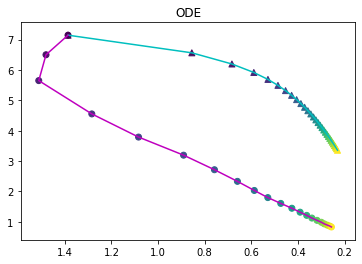

In [30]:
if ( flagAEType == 0 ) :

    LVarDescent = loss4DVarODE.shape[0]
    LLSTMDescent = loss_LSTMDescentODE.shape[0]

    plt.figure(2)
    plt.plot(loss4DVarODE[:,0], loss4DVarODE[:,1],'c-')
    plt.scatter(loss4DVarODE[:,0], loss4DVarODE[:,1], c=np.arange(LVarDescent),marker='^')
    plt.plot(loss_LSTMDescentODE[:,0], loss_LSTMDescentODE[:,1],'m-')
    sca = plt.scatter(loss_LSTMDescentODE[:,0], loss_LSTMDescentODE[:,1], c=np.arange(LLSTMDescent),marker='o')
    #plt.yscale('log')
    sca.axes.invert_xaxis()
    plt.title('ODE')

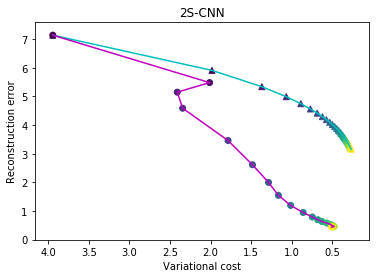

In [20]:
if ( flagAEType == 1 ) :

    LVarDescent = loss4DVar2SCNN.shape[0]
    LLSTMDescent = loss_LSTMDescent2SCNN.shape[0]

    plt.figure(2)
    plt.plot(loss4DVar2SCNN[:,0], loss4DVar2SCNN[:,1],'c-')
    plt.scatter(loss4DVar2SCNN[:,0], loss4DVar2SCNN[:,1], c=np.arange(LVarDescent),marker='^')
    plt.plot(loss_LSTMDescent2SCNN[:,0], loss_LSTMDescent2SCNN[:,1],'m-')
    sca = plt.scatter(loss_LSTMDescent2SCNN[:,0], loss_LSTMDescent2SCNN[:,1], c=np.arange(LLSTMDescent),marker='o')
    #plt.yscale('log')
    sca.axes.invert_xaxis()
    plt.xlabel('Variational cost')
    plt.ylabel('Reconstruction error')
    plt.title('2S-CNN')

In [ ]:
# Visualisation of reconstructed images

...... Reconstruction error #221
.. Initialisation    : 3.7688e-01
.. ODE FSGD Solver   : 1.6805e-01
.. ODE LSTM Solver   : 4.2367e-02
.. 2S-CNN FSGD Solver: 1.5209e-01
.. 2S-CNN LSTM Solver: 1.5664e-02


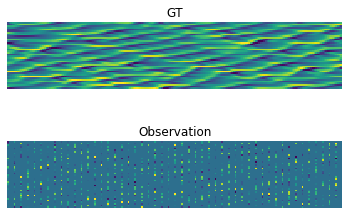

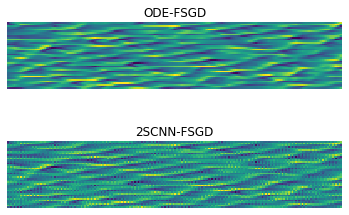

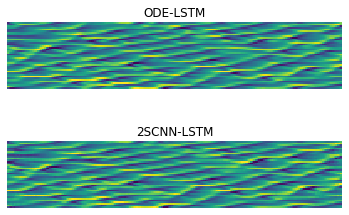

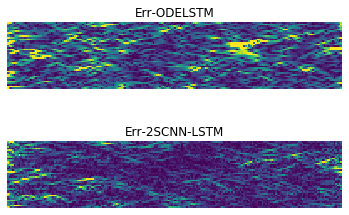

In [31]:
Vmin = -2
Vmax = 2

ii = 0

plt.figure(1)
plt.subplot(2,1,1)
plt.imshow(x_test[idxTt[ii],:,:].squeeze(),cmap='viridis',vmin=Vmin,vmax=Vmax)
plt.axis('off')
plt.title('GT')


plt.subplot(2,1,2)
#plt.figure(2)
plt.imshow(x_test_obs[idxTt[ii],:,:].squeeze(),cmap='viridis',vmin=Vmin,vmax=Vmax)
plt.axis('off')
plt.title('Observation')

plt.figure(2)
if 'y_pred_LSTMDescentODE' in locals():
    plt.subplot(2,1,1)
    #plt.figure(4)
    plt.imshow(y_pred_VarMinODE[ii,:,:].squeeze(),cmap='viridis',vmin=Vmin,vmax=Vmax)
    plt.axis('off')
    plt.title('ODE-FSGD')

if 'y_pred_LSTMDescent2SCNN' in locals():
    plt.subplot(2,1,2)
    plt.imshow(y_pred_VarMin2SCNN[ii,:,:].squeeze(),cmap='viridis',vmin=Vmin,vmax=Vmax)
    plt.axis('off')
    plt.title('2SCNN-FSGD')


plt.figure(3)
if 'y_pred_LSTMDescentODE' in locals():
    plt.subplot(2,1,1)
    plt.imshow(y_pred_LSTMDescentODE[ii,:,:].squeeze(),cmap='viridis',vmin=Vmin,vmax=Vmax)
    plt.axis('off')
    plt.title('ODE-LSTM')

if 'y_pred_LSTMDescent2SCNN' in locals():
    plt.subplot(2,1,2)
    #plt.figure(5)
    plt.imshow(y_pred_LSTMDescent2SCNN[ii,:,:].squeeze(),cmap='viridis',vmin=Vmin,vmax=Vmax)
    plt.axis('off')
    plt.title('2SCNN-LSTM')

plt.figure(4)
if 'y_pred_LSTMDescentODE' in locals():
    plt.subplot(2,1,1)
    plt.imshow(np.abs(y_pred_LSTMDescentODE[ii,:,:].squeeze()-x_test[idxTt[ii],:,:].squeeze()),cmap='viridis',vmin=0,vmax=0.5)
    plt.axis('off')
    plt.title('Err-ODELSTM')

if 'y_pred_LSTMDescent2SCNN' in locals():
    plt.subplot(2,1,2)
    #plt.figure(5)
    plt.imshow(np.abs(y_pred_LSTMDescent2SCNN[ii,:,:].squeeze()-x_test[idxTt[ii],:,:].squeeze()),cmap='viridis',vmin=0,vmax=0.5)
    plt.axis('off')
    plt.title('Err-2SCNN-LSTM')


print('...... Reconstruction error #%d'%idxTt[ii])
print('.. Initialisation    : %.4e'%np.mean( (x_test_Init[idxTt[ii],:,:]-x_test[idxTt[ii],:,:])**2 ))
if 'y_pred_LSTMDescentODE' in locals():
    print('.. ODE FSGD Solver   : %.4e'%np.mean( (y_pred_VarMinODE[ii,:,:]-x_test[idxTt[ii],:,:])**2 ))
    print('.. ODE LSTM Solver   : %.4e'%np.mean( (y_pred_LSTMDescentODE[ii,:,:]-x_test[idxTt[ii],:,:])**2 ))
if 'y_pred_LSTMDescent2SCNN' in locals():
    print('.. 2S-CNN FSGD Solver: %.4e'%np.mean( (y_pred_VarMin2SCNN[ii,:,:]-x_test[idxTt[ii],:,:])**2 ))
    print('.. 2S-CNN LSTM Solver: %.4e'%np.mean( (y_pred_LSTMDescent2SCNN[ii,:,:]-x_test[idxTt[ii],:,:])**2 ))